# stochastic analysis of COVID19 time series in "Baden-Württemberg"
data as of 10.06.2020 by https://sozialministerium.baden-wuerttemberg.de/de/gesundheit-pflege/gesundheitsschutz/infektionsschutz-hygiene/informationen-zu-coronavirus/lage-in-baden-wuerttemberg/

algorithm from "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec [1]

In [1]:
import pandas as pd
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
import datetime

## 1. extract values from selected list
variables names: *I: Infected; *T: Deceased

In [2]:
filename = 'Tabelle_Coronavirus-Faelle-BW.xlsx'
dfi = pd.read_excel(filename, sheet_name='Infizierte Coronavirus in BW', header=None)
dft = pd.read_excel(filename, sheet_name='Todesfälle Coronavirus in BW', header=None)

In [5]:
ctyI = np.nan_to_num(np.asarray(dfi))
ctyT = np.nan_to_num(np.asarray(dft))
# row 7: dates
# row 8 to 51: regions
    # row 18: Freiburg
    # row 38: Ravensburg
# row 52: sum

### plot regional data

In [89]:
index = 17
region = ctyI[index][0]
title = 'Corona cases in %s' % region

# calculate x data: dates
# currently: approximation where each month is approximated by 30 days.
xI = [el.day+el.month*30 if type(el) == datetime.datetime else False for el in ctyI[6]]
xT = [el.day+el.month*30 if type(el) == datetime.datetime else False for el in ctyT[6]]

# calculate trajectory points from data of given index
yI = [el if type(el) == int else False for el in ctyI[index]]
yT = [el if type(el) == int else False for el in ctyT[index]]

# remove first element of lists (column of regions, only str in these)
del xI[0]
del xT[0]
del yI[0]
del yT[0]

# flip arrays
xI = np.flip(xI)
xT = np.flip(xT)
yI = np.flip(yI)
yT = np.flip(yT)

# Calculate new cases per day
dyIdt = np.diff(yI, prepend=0)
    
# Calculate new deaths per day
dyTdt = np.diff(yT,prepend=0)

# Checking for mistakes
print('I1:', len(xI) == len(yI))
print('T1:', len(xT) == len(yT))
print('dIdt:', len(xI) == len(dyIdt))
print('dTdt:', len(xT) == len(dyTdt))
checksum = 0
for el in dyIdt:
    checksum += el
print("checksum I:", checksum == yI[-1])
checksum = 0
for el in dyTdt:
    checksum += el
print("checksum T:", checksum == yT[-1])

I1: True
T1: True
dIdt: True
dTdt: True
checksum I: True
checksum T: True


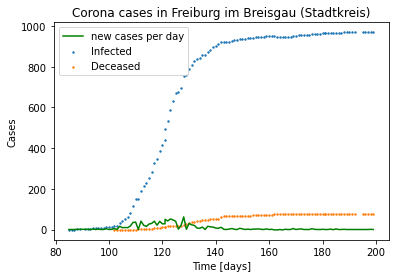

In [88]:
# Plot infected, deceased and new cases per day
plt.scatter(xI, yI, label='Infected', s=2)
plt.scatter(xT, yT, label='Deceased', s=2)
plt.plot(xI, dyIdt, label='new cases per day', c='g')
plt.xlabel('Time [days]')
plt.ylabel('Cases')
plt.title(title)
plt.legend(loc='upper left')
plt.show()
#plt.savefig('%sCases.png' % region)

### plot total data

In [14]:
# calculation of x-data in cell above

# calculate total sum
yI_total = [el for el in ctyI[51]]
yT_total = [el for el in ctyT[51]]

# remove first element of lists (column of regions, only str in these)
del yI_total[0]
del yT_total[0]

# flip arrays
yI_total = np.flip(yI_total)
yT_total = np.flip(yT_total)

# Calculate new cases per day
dyI_totaldt = np.diff(yI_total, prepend=0)
    
# Calculate new deaths per day
dyT_totaldt = np.diff(yT_total, prepend=0)
    
# Checking for mistakes
print('I2:', len(xI) == len(yI_total))
print('T2:', len(xT) == len(yT_total))
print('dI_totaldt:', len(xI) == len(dyI_totaldt))
print('dT_totaldt:', len(xT) == len(dyT_totaldt))
checksum = 0
for el in dyI_totaldt:
    checksum += el
print("checksum I:", checksum == yI_total[-1])
checksum = 0
for el in dyT_totaldt:
    checksum += el
print("checksum T:", checksum == yT_total[-1])

I2: True
T2: True
dI_totaldt: True
dT_totaldt: True
checksum I: True
checksum T: True


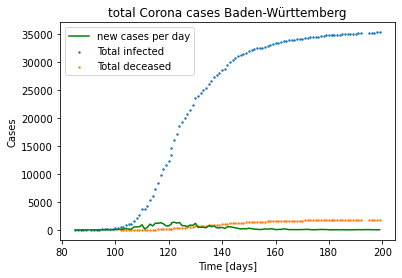

In [18]:
# Plot infected, deceased and new cases per day
plt.scatter(xI, yI_total, label='Total infected', s=2)
plt.scatter(xT, yT_total, label='Total deceased', s=2)
plt.plot(xI, dyI_totaldt, label='new cases per day', c='g')
plt.xlabel('Time [days]')
plt.ylabel('Cases')
plt.title('total Corona cases Baden-Württemberg')
plt.legend(loc='upper left')
plt.show()
#plt.savefig('BWCases.png')

## 2. stochastic analysis

### conditional probability function

In [114]:
# All probability functions shall be moved into a seperate class, so that some distributions can be saved.
# This will reduce processor load.

def P_x(x, x_val):
    '''Probability Distribution
    
    Returns the probability for x having the value x_val.
    
    Parameters:
        - (np.array of int) x: Represents the time series to calculate the probability from.
        - (float) x_val: The value to search for.
        
    Inherited as P_x(y, t) from [2].
    
    [!] function is not yet verified!
    '''
    a = np.where(x == x_val, 1, 0)
    b = np.sum(a)
    result = b / len(x)
    
    return result

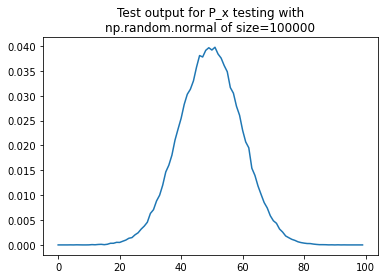

In [115]:
# Testing and plotting P_x
a = np.random.normal(50, 10, 100000).astype(int)
out = []
for i in range(100):
    out.append(P_x(a, i))
plt.clf()
plt.plot(out)
plt.title('Test output for P_x testing with\nnp.random.normal of size=100000')
plt.show()

In [116]:
def P_1(y, y_val, t):
    '''Probability Distribution function
    inherited from (9.54)[2]
    
    Calculates the probability distribution for y having the value y_val.
    at time t.
    
    Parameters:
        - (np.array) y: time series.
        - (float) y_val: the value y shall have at time t.
        - (int) t: time to be examined.
    '''
    if (y_val - y[t] == 0):
        return P_x(y, y_val)
    else:
        return 0

def P_comp(y, y_val, t):
    '''Compound Probability function
    inherited from (9.55)[2]
    
    Parameters:
        - (np.array) y: time series.
        - (np.array) y_val: values y shall have at times t.
        - (np.array) t: times.
        
    Requirements:
        >>> len(y_val) == len(t)
    '''
    if (len(y_val) != len(t)):
        raise TypeError("y_val and t must have the same size.")
    
    result = 0
    r = True
    for i in range(len(y_val)):
        if (y_val[i] - y[t[i]] != 0):
            r = False
            break;
        else:
            result += P_x(y, y_val[i])
            
    return result if r else 0

def P_cond(y, y_val, t, y_val_, t_):
    '''Conditional Probabilty function
    inherited from (9.58)[2]
    
    Conditional Probability is the probability-density for Y having at time t_2 the value y_2
    when at time t_1 the value y_1 was present.
    '''
    denominator = P_comp(y, y_val, t)
    nominator = P_comp(y, y_val_, t_)
    
    result = denominator / nominator
    return result

In [117]:
# Testing P_cond
y = np.arange(1000)
y_val = [0, 2, 4, 5, 6, 7, 8, 9, 0]
t = [0, 2, 4, 5, 6, 7, 8, 9, 0]

print('Overlap test:', [y[t[i]] == y_val[i] for i in range(len(t))])

out_0 = P_comp(y, y, y)
print('Inaccuracy test:', out_0 - 1.0)
print('-- at array length 100000:', '-1.916244940503020e-12')
print('-- at array length 10000 :', '-9.381384558082573e-14')
print('-- at array length 1000  :', '+6.661338147750939e-16')

out_1 = P_cond(y, y_val, t, y_val[:2], t[:2])
print(out_1)

Overlap test: [True, True, True, True, True, True, True, True, True]
Inaccuracy test: 6.661338147750939e-16
-- at array length 100000: -1.916244940503020e-12
-- at array length 10000 : -9.381384558082573e-14
-- at array length 1000  : +6.661338147750939e-16
4.5


### determine drift- and diffusion-coefficients

In [118]:
# eval parameter definition
tau = 0.01

def T_1(x, i, tau):
    pass
    
def T_2(x, y, i, j, tau):
    pass

def D_1(i, x):
    return T_1(i, x, tau)

def D_2(i, j, x):
    return T_2(i, j, x, tau) - tau * T_1(i, x, tau) * T_1(j, x, tau)

### resulting Fokker-Planck equation

## literature

[1] "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec

[2] "Simulation - Advanced Topics" by A.Greiner as of June 11, 2020